# Optimization methods & acceleration

In [141]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import sklearn.linear_model as sk_lm
import statsmodels.api as sm
import imp
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#import numdifftools

In [3]:
import numpy as np
from scipy.special import psi
from statsmodels.sandbox.regression.gmm import GMM

In [4]:
!pwd

/home/mkim7/Github/scrna-parameter-estimation/examples/simulation/method_of_moments


In [11]:
sys.path

['/home/mkim7/Github/scrna-parameter-estimation/examples/simulation/method_of_moments',
 '/home/mkim7/anaconda3/envs/single_cell/lib/python37.zip',
 '/home/mkim7/anaconda3/envs/single_cell/lib/python3.7',
 '/home/mkim7/anaconda3/envs/single_cell/lib/python3.7/lib-dynload',
 '',
 '/home/mkim7/anaconda3/envs/single_cell/lib/python3.7/site-packages',
 '/home/mkim7/anaconda3/envs/single_cell/lib/python3.7/site-packages/IPython/extensions',
 '/home/mkim7/.ipython',
 'Github/scrna-parameter-estimation/examples/simulation/simulate.py',
 '/home/mkim7/Github/scrna-parameter-estimation/examples/simulation/simulate.py']

In [6]:
import sys

In [14]:
import sys
sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/examples/simulation')
import simulate as sim

In [15]:
p = 0.1
noise_level = 0.2049755522580501
p_sq = (noise_level+1)*p**2

In [31]:
imp.reload(sim)

<module 'simulate' from '/home/mkim7/Github/scrna-parameter-estimation/examples/simulation/simulate.py'>

In [140]:
X, z = sim.simulate_true_counts(
    N=10000,
    mean_coef = np.array([0.5, 0.5]),
    var_coef = np.array([1, 0.5]),
    num_levels=3,
    p=1)

y = sim.simulate_dropout(z, p, p_sq)
df_raw = pd.DataFrame(
    data=np.hstack([X, y]),
    columns=['treatment', 'intercept', 'y'])
df_means = df_raw.groupby(['treatment', 'intercept'])['y'].mean()
df_raw = df_raw.groupby(['treatment', 'intercept']).size().reset_index(name='count')
df_raw['mean'] = df_means.values

hi


In [133]:
df_raw.head(5)

,treatment,intercept,count,mean
0,0,1,3264,0.424482
1,1,1,3342,1.016972
2,2,1,3394,1.504536


In [137]:
lm = sk_lm.LinearRegression().fit(df_raw['treatment'].values.reshape(-1, 1), df_raw['mean'], sample_weight=df_raw['count'])

In [139]:
lm.coef_

array([0.53968414])

In [131]:
stats.linregress(df_raw['treatment'], df_means)

LinregressResult(slope=0.5400265721323865, intercept=0.44197027622371265, rvalue=0.9984306916630515, pvalue=0.03567024343911022, stderr=0.03028976428242153)

In [95]:
df = pd.DataFrame(
    data=np.hstack([X, y]),
    columns=['treatment','intercept', 'y'])
df = df.groupby(df.columns.tolist()).size().reset_index(name='count')
df['proportion'] = df['count'] / X.shape[0]

init = np.ones(3)*(np.log(y+1).mean()/2)

mean_model = MeanGMM(y, X, instrument=None, q=p, q_sq=p_sq)
mean_model.nobs = y.shape[0]
mean_res = mean_model.fit(None, maxiter=2, optim_method='bfgs', optim_args={'disp':False}, wargs=dict(centered=False))
mean_beta = mean_res.params

# var_model = VarianceGMM(y, X, instrument=None, q=p, q_sq=p_sq, mean_beta=mean_beta, gamma=1)
# var_res = var_model.fit(None, maxiter=2, optim_method='bfgs', optim_args={'disp':False}, wargs=dict(centered=False))

# combined_model = CombinedGMM(y, X, instrument=None, q=p, q_sq=p_sq, gamma=1)
# combined_res = combined_model.fit(np.concatenate([init, init]), maxiter=2, optim_method='bfgs', optim_args={'disp':False}, wargs=dict(centered=False))


print(mean_res.summary())
#|print(var_res.summary())
# print(combined_res.summary())

                               MeanGMM Results                                
Dep. Variable:                      y   Hansen J:                    9.565e-10
Model:                        MeanGMM   Prob (Hansen J):                   nan
Method:                           GMM                                         
Date:                Mon, 02 Mar 2020                                         
Time:                        15:05:47                                         
No. Observations:               10000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4757      0.030     15.630      0.000       0.416       0.535
const          0.5653      0.040     14.184      0.000       0.487       0.643


In [ ]:
+ (1.548551-0.494326))/2

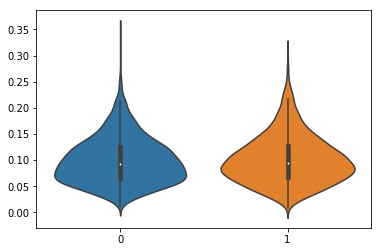

In [10]:
sns.violinplot(pd.Series(X[:, 0]), y.ravel())

### Naive implementation

In [143]:
class MeanGMM(GMM):

    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 2)
        kwds.setdefault('k_params', 2)
        super(MeanGMM, self).__init__(*args, **kwds)
        
    
    def fitstart(self):
        
        y = self.endog.reshape(-1, 1)/self.q
        x_mat = self.exog
        ylog = np.log(y+1)
        sol, _, _, _ = np.linalg.lstsq(x_mat, ylog, rcond=-1)
        
        return sol.reshape(-1)


    def momcond(self, params):
                
        y = self.endog.reshape(-1, 1)
        x_mat = self.exog

        beta_hat = params.reshape(-1, 1)
        
        a =  (x_mat*y)/self.q - (x_mat*np.exp(x_mat@beta_hat))
        return a
    
class VarianceGMM(GMM):

    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 2)
        kwds.setdefault('k_params', 2)
        super(VarianceGMM, self).__init__(*args, **kwds)
        
        
    def fitstart(self):
        
        y = self.endog.reshape(-1, 1)/self.q
        ylog = np.log(y+1)
        x_mat = self.exog
        mean_beta = self.mean_beta.reshape(-1, 1)
        
        res = (ylog-x_mat@mean_beta)**2
        sol, _, _, _ = np.linalg.lstsq(x_mat, res, rcond=-1)
        return sol.reshape(-1)

    def momcond(self, params):
                
        y = self.endog.reshape(-1, 1)
        x_mat = self.exog
        mean_beta = self.mean_beta.reshape(-1, 1)

        var_beta = params.reshape(-1, 1)
        
        a = (x_mat*y**2)/self.q_sq
        b = -(x_mat*y)*(1-self.q_sq/self.q)/self.q_sq
        c = -2*y*np.exp(x_mat@mean_beta)*x_mat/self.q
        d = np.exp(2*x_mat@mean_beta)*x_mat
        e = -x_mat*np.exp(x_mat@(self.gamma*mean_beta + var_beta))
        return a + b + c + d + e

class CombinedGMM(GMM):
    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 4)
        kwds.setdefault('k_params', 4)
        super(CombinedGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
                
        y = self.endog.reshape(-1, 1)
        x_mat = self.exog

        mean_beta, var_beta = np.split(params.reshape(-1, 1), 2)
                
        mean_error =  (x_mat*y)/self.q - (x_mat*np.exp(x_mat@mean_beta))
        
        a = (x_mat*y**2)/self.q_sq
        b = -(x_mat*y)*(1-self.q_sq/self.q)/self.q_sq
        c = -2*y*np.exp(x_mat@mean_beta)*x_mat/self.q
        d = np.exp(2*x_mat@mean_beta)*x_mat
        e = -x_mat*np.exp(x_mat@(self.gamma*mean_beta + var_beta))
        
        var_error = a + b + c + d + e
    
        return np.hstack([mean_error, var_error])

In [144]:
imp.reload(sim)

<module 'simulate' from '/home/mkim7/Github/scrna-parameter-estimation/examples/simulation/simulate.py'>

In [145]:
X, z = sim.simulate_true_counts(
    N=10000,
    mean_coef = np.array([1.0, 0.1]),
    var_coef = np.array([1.6, 0.1]),
    num_levels=3,
    p=1)

y = sim.simulate_dropout(z, p, p_sq).reshape(-1, 1)

hi


In [148]:
df = pd.DataFrame(
    data=np.hstack([X, y]),
    columns=['treatment','intercept', 'y'])
df = df.groupby(df.columns.tolist()).size().reset_index(name='count')
df['proportion'] = df['count'] / X.shape[0]

init = np.ones(3)*(np.log(y+1).mean()/2)

mean_model = MeanGMM(y, X, instrument=None, q=p, q_sq=p_sq)
mean_model.nobs = y.shape[0]
mean_res = mean_model.fit(None, maxiter=2, optim_method='bfgs', optim_args={'disp':False}, wargs=dict(centered=False))
mean_beta = mean_res.params

var_model = VarianceGMM(y, X, instrument=None, q=p, q_sq=p_sq, mean_beta=mean_beta, gamma=1)
var_res = var_model.fit(None, maxiter=2, optim_method='bfgs', optim_args={'disp':False}, wargs=dict(centered=False))

# combined_model = CombinedGMM(y, X, instrument=None, q=p, q_sq=p_sq, gamma=1)
# combined_res = combined_model.fit(np.concatenate([init, init]), maxiter=2, optim_method='bfgs', optim_args={'disp':False}, wargs=dict(centered=False))


print(mean_res.summary())
print(var_res.summary())
# print(combined_res.summary())

                               MeanGMM Results                                
Dep. Variable:                      y   Hansen J:                    6.475e-10
Model:                        MeanGMM   Prob (Hansen J):                   nan
Method:                           GMM                                         
Date:                Mon, 02 Mar 2020                                         
Time:                        16:05:34                                         
No. Observations:               10000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9843      0.036     27.655      0.000       0.915       1.054
const          0.1495      0.047      3.190      0.001       0.058       0.241
                             VarianceGMM Results                              
Dep. Variable:                      y   Hansen J:   

In [96]:
np.log(df_raw.groupby(['treatment'])['y'].mean()/p)

treatment
0    0.518651
1    1.483780
Name: y, dtype: float64

In [91]:
np.log(df_raw.groupby(['treatment', 'batch'])['y'].mean()/p)

treatment  batch
0          0        0.504153
           1        0.533298
1          0        1.475929
           1        1.491695
Name: y, dtype: float64

### Proportion based GMMs

In [160]:
class FasterMeanGMM(GMM):

    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 2)
        kwds.setdefault('k_params', 2)
        super(FasterMeanGMM, self).__init__(*args, **kwds)
        
    
    def fitstart(self):
        
        y_val, y_counts = self.endog[:, 0].reshape(-1, 1), self.endog[:, 1].reshape(-1, 1)
        x_mat = self.exog
        
        ylog = np.log(y_val+1)
        sol, _, _, _ = np.linalg.lstsq(x_mat*y_counts, ylog*y_counts, rcond=-1)
        
        return sol.reshape(-1)


    def momcond(self, params):
                
        y_means, y_counts = self.endog[:, 0].reshape(-1, 1), self.endog[:, 1].reshape(-1, 1)
        x_mat = self.exog

        beta_hat = params.reshape(-1, 1)
        
        a =  (x_mat*y_means)/self.q - (x_mat*np.exp(x_mat@beta_hat))
        
        #print(a.shape, y_counts.shape)
        return a * y_counts


In [161]:
class FastMeanGMM(GMM):

    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 2)
        kwds.setdefault('k_params', 2)
        super(FastMeanGMM, self).__init__(*args, **kwds)
        
    
    def fitstart(self):
        
        y_val, y_counts = self.endog[:, 0].reshape(-1, 1), self.endog[:, 1].reshape(-1, 1)
        x_mat = self.exog
        
        ylog = np.log(y_val+1)
        sol, _, _, _ = np.linalg.lstsq(x_mat*y_counts, ylog*y_counts, rcond=-1)
        
        return sol.reshape(-1)


    def momcond(self, params):
                
        y_val, y_counts = self.endog[:, 0].reshape(-1, 1), self.endog[:, 1].reshape(-1, 1)
        x_mat = self.exog

        beta_hat = params.reshape(-1, 1)
        
        a =  (x_mat*y_val)/self.q - (x_mat*np.exp(x_mat@beta_hat))
        
        #print(a.shape, y_counts.shape)
        return a * y_counts


In [742]:
X, z = sim.simulate_true_counts(
    N=5000,
    mean_coef = np.array([1.0, 0.1]),
    var_coef = np.array([1.6, 0.1]),
    num_levels=3,
    p=1)

y = sim.simulate_dropout(z, p, p_sq).reshape(-1, 1)

hi


In [743]:
df = pd.DataFrame(
    data=np.hstack([X, y]),
    columns=['treatment', 'intercept', 'y'])
df = df.groupby(df.columns.tolist()).size().reset_index(name='count')
df['proportion'] = df['count'] / X.shape[0]

In [744]:
df_faster = pd.DataFrame(
    data=np.hstack([X, y]),
    columns=['treatment', 'intercept', 'y'])
df_faster_counts = df_faster.groupby(['treatment', 'intercept']).size()
df_faster = df_faster.groupby(['treatment', 'intercept'])['y'].mean().reset_index(name='mean')
df_faster['count'] = df_faster_counts.values
#df['proportion'] = df['count'] / X.shape[0]

In [745]:
df_faster

,treatment,intercept,mean,count
0,0,1,0.105455,1650
1,1,1,0.319653,1730
2,2,1,0.759259,1620


In [676]:
%%time
mean_model = FasterMeanGMM(
    df_faster[['mean', 'count']].values, 
    df_faster[['treatment', 'intercept']].values,
    instrument=None, q=p, q_sq=p_sq)
mean_res = mean_model.fit(np.array([1 , 0.1]), maxiter=2, optim_method='bfgs', optim_args={'disp':False}, wargs=dict(centered=False))
print(mean_res.summary())




                            FasterMeanGMM Results                             
Dep. Variable:           ['y1', 'y2']   Hansen J:                    5.989e-15
Model:                  FasterMeanGMM   Prob (Hansen J):                   nan
Method:                           GMM                                         
Date:                Mon, 02 Mar 2020                                         
Time:                        23:37:24                                         
No. Observations:                   3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0043      0.026     38.565      0.000       0.953       1.055
const          0.1583      0.051      3.079      0.002       0.058       0.259
CPU times: user 14.3 ms, sys: 56 µs, total: 14.3 ms
Wall time: 11.6 ms


In [677]:
%%time
mean_model = FastMeanGMM(
    df[['y', 'count']].values, 
    df[['treatment', 'intercept']].values,
    instrument=None, q=p, q_sq=p_sq)
mean_res = mean_model.fit(np.array([1 , 0.1]), maxiter=2, optim_method='bfgs', optim_args={'disp':False}, wargs=dict(centered=False))
print(mean_res.summary())




                             FastMeanGMM Results                              
Dep. Variable:           ['y1', 'y2']   Hansen J:                    9.721e-18
Model:                    FastMeanGMM   Prob (Hansen J):                   nan
Method:                           GMM                                         
Date:                Mon, 02 Mar 2020                                         
Time:                        23:37:27                                         
No. Observations:                  26                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0043      0.678      1.482      0.138      -0.324       2.333
const          0.1583      1.031      0.154      0.878      -1.863       2.180
CPU times: user 15.2 ms, sys: 3 µs, total: 15.2 ms
Wall time: 11.9 ms


In [30]:
mean_res.params

array([1.00345407, 0.1098364 ])

In [31]:
mean_res.params

array([1.00345407, 0.1098364 ])

### Numerical optimization for mean

In [32]:
X, z = sim.simulate_true_counts(
    N=10000,
    mean_coef = np.array([1.0, 0.1]),
    var_coef = np.array([1.6, 0.1]),
    num_levels=2,
    p=1)

y = sim.simulate_dropout(z, p, p_sq)

df = pd.DataFrame(
    data=np.hstack([X, y]),
    columns=['treatment', 'intercept', 'y'])
df = df.groupby(df.columns.tolist()).size().reset_index(name='count')
df['proportion'] = df['count'] / X.shape[0]
df['count_2'] = df['count'] + np.random.randint(0, 10, size=df.shape[0])

lol


In [33]:
def fit_start():
    
    y_val, y_counts = df['y'].values.reshape(-1, 1), df['count'].values.reshape(-1, 1)
    x_mat = df[['treatment', 'intercept']].values

    ylog = np.log(y_val+1)
    sol, _, _, _ = np.linalg.lstsq(x_mat*y_counts, ylog*y_counts, rcond=-1)

    return sol.reshape(-1)

In [34]:
y_val, y_counts_1, y_counts_2 = \
    df['y'].values.reshape(-1, 1), \
    df['count'].values.reshape(-1, 1), \
    df['count_2'].values.reshape(-1, 1)
    
x_mat = df[['treatment', 'intercept']].values

In [42]:
y_counts = df[['count', 'count_2', 'count_2']].values.reshape(-1, 1, 3)

In [43]:
res = x_mat.reshape(14, 2, -1)*y_counts

ValueError: cannot reshape array of size 22 into shape (14,2,newaxis)

In [41]:
res.mean(axis=0)

NameError: name 'res' is not defined

In [327]:
res.shape

(14, 2, 3)

### Figure out dimensions and broadcasting

In [408]:
y_val, y_counts = df['y'].values.reshape(-1, 1), df[['count', 'count_2']].values.reshape(-1, 1, 2)
x_mat = df[['treatment', 'intercept']].values

beta_hat = np.vstack([np.array([1.0, 0.1]), np.array([1.1, 0.1])]).T

In [409]:
part_1 = ((x_mat*y_val)/p)
part_1 = part_1.reshape(part_1.shape[0], part_1.shape[1], -1)

part_2 = x_mat.reshape(x_mat.shape[0], x_mat.shape[1], -1)

part_3 = np.exp(x_mat@beta_hat).reshape(-1, 1, beta_hat.shape[1])

momcond = (part_1 - part_2*part_3)
weighted_momcond = momcond * y_counts

In [410]:
weighted_momcond.mean(axis=0)

array([[  5.00231439, -14.26233438],
       [ 16.47488939,  13.40962709]])

In [340]:
def mean_objective_perm(params):

    y_val, y_counts = df['y'].values.reshape(-1, 1), df[['count', 'count_2']].values.reshape(-1, 1, 2)
    x_mat = df[['treatment', 'intercept']].values

    beta_hat = params.reshape(-1, 1)

    a =  ((x_mat*y_val)/p - (x_mat*np.exp(x_mat@beta_hat)))
    a = a.reshape(a.shape[0], a.shape[1], -1)

    momcond = (a * y_counts).mean(axis=0)
    
    return (momcond**2).sum()

In [509]:
def mean_objective(params):

    y_val, y_counts = df['y'].values.reshape(-1, 1), df['proportion'].values.reshape(-1, 1)
    x_mat = df[['treatment', 'intercept']].values

    beta_hat = params.reshape(-1, 1)

    a =  (x_mat*y_val)/p - (x_mat*np.exp(x_mat@beta_hat))

    momcond = (a * y_counts).mean(axis=0)
    
    return (momcond**2).sum()

In [274]:
start = fit_start()

In [293]:
%%time
sp.optimize.minimize(
    mean_objective, 
    np.array([1.0, 0.1]),
    method='Nelder-Mead', 
    options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.000033
         Iterations: 39
         Function evaluations: 74
CPU times: user 115 ms, sys: 0 ns, total: 115 ms
Wall time: 108 ms


 final_simplex: (array([[1.02132555, 0.07663115],
       [1.02132684, 0.07662921],
       [1.02132248, 0.07663292]]), array([3.30314006e-05, 7.17309876e-05, 9.95056087e-05]))
           fun: 3.303140063249221e-05
       message: 'Optimization terminated successfully.'
          nfev: 74
           nit: 39
        status: 0
       success: True
             x: array([1.02132555, 0.07663115])

### Number of simultaneous function evals - optimal number

In [963]:
np.logspace(2, 5, 10)

array([   100.        ,    215.443469  ,    464.15888336,   1000.        ,
         2154.43469003,   4641.58883361,  10000.        ,  21544.34690032,
        46415.88833613, 100000.        ])

In [965]:
import time

In [469]:
num_perms = np.logspace(0, 7, 30)
times = np.zeros(num_perms.shape[0])
for idx, num_perm in enumerate(num_perms):
    
    num_perm = int(num_perm)
    
    X, z = sim.simulate_true_counts(
    N=N,
    mean_coef = np.array([1.0, 0.1]),
    var_coef = np.array([1.6, 0.1]),
    num_levels=2,
    p=1)

    y = sim.simulate_dropout(z, p, p_sq)
    
    perm_start = np.concatenate([np.array([1.5, 0.1]) for i in range(num_perm)])

    df = pd.DataFrame(
        data=np.hstack([X, y]),
        columns=['treatment', 'intercept', 'y'])
    df = df.groupby(df.columns.tolist()).size().reset_index(name='count')
    df['proportion'] = df['count'] / X.shape[0]

    perm_proportions = stats.multinomial.rvs(
        N, 
        df['proportion'], 
        size=num_perm).T
    
    start = time.time()
    
    val = mean_objective_perm(perm_start)
    
    times[idx] = time.time() - start

hi


NameError: name 'time' is not defined

### Generate multivariate permutations

In [563]:
perm_start = np.concatenate([np.array([1.0, 0.1]) for i in range(num_perm)])

In [680]:
# for a single permutation
params = np.array([1, 0.1]).reshape((-1, 1))
x_mat = df_mean[['treatment', 'intercept']].values
y_val = df_mean['group_mean'].values.reshape((-1, 1))
y_counts = df_mean['group_mean'].values.reshape((-1, 1))

In [681]:
part_1 = x_mat*y_val
part_2 = x_mat*np.exp(x_mat@params)
momcond = part_1 -part_2

In [564]:
x_mat = df_mean[['treatment', 'intercept']].values.reshape((df_mean.shape[0], -1, 1))
y_val, y_counts = np.tile(perm_means.reshape(-1, 1, perm_means.shape[1]), (1, 2, 1)), perm_counts.reshape(-1, 1, perm_means.shape[1])
beta_hat = perm_start.reshape(-1, num_perm, order='F')

In [565]:
perm_means

array([[0.11347105, 0.10823392, 0.11638056, ..., 0.11347105, 0.10823392,
        0.11201629],
       [0.30516288, 0.30700676, 0.30362631, ..., 0.3057775 , 0.32267978,
        0.29532883],
       [0.81051677, 0.87549108, 0.78392264, ..., 0.89724992, 0.87277123,
        0.80628589]])

In [566]:
x_mat = df_mean[['treatment', 'intercept']].values
y_val, y_counts = perm_means, perm_counts
beta_hat = perm_start.reshape(-1, num_perm, order='F')

In [567]:
y_val.shape

(3, 10000)

In [568]:
x_mat.shape

(3, 2)

In [569]:
np.exp(x_mat@beta_hat).shape

(3, 10000)

In [570]:
temp1 = part_2*part_3
temp2 = np.einsum('nm,nk->nmk', x_mat,np.exp(x_mat@beta_hat) )

In [571]:
(temp1 == temp2).mean()

1.0

In [572]:
# part_1 = np.einsum('nm,nk->nmk', x_mat, y_val)
# part_2 = x_mat.reshape(x_mat.shape[0], x_mat.shape[1], -1)
# part_3 = np.exp(x_mat@beta_hat).reshape(-1, 1, num_perm)
momcond = np.einsum('nm,nk->nmk', x_mat, y_val) - np.einsum('nm,nk->nmk', x_mat,np.exp(x_mat@beta_hat) )


In [577]:
momcond

array([[[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [ -0.99169987,  -0.99693699,  -0.98879035, ...,  -0.99169987,
          -0.99693699,  -0.99315462]],

       [[ -2.69900315,  -2.69715926,  -2.70053972, ...,  -2.69838852,
          -2.68148625,  -2.7088372 ],
        [ -2.69900315,  -2.69715926,  -2.70053972, ...,  -2.69838852,
          -2.68148625,  -2.7088372 ]],

       [[-14.71130628, -14.58135766, -14.76449455, ..., -14.53783998,
         -14.58679737, -14.71976805],
        [ -7.35565314,  -7.29067883,  -7.38224728, ...,  -7.26891999,
          -7.29339868,  -7.35988403]]])

In [578]:
weighted_1.shape

(3, 2, 10000)

In [586]:
weighted_1 = (momcond * perm_counts.reshape((perm_counts.shape[0], 1, -1))).mean(axis=0)
weighted_2 = np.einsum('ijk,ik->ijk', momcond, perm_counts).mean(axis=0)

In [583]:
weighted_1.mean(axis=0).shape

(2, 10000)

In [555]:
perm_counts.reshape((perm_counts.shape[0], 1, -1))

array([[[3417., 3377., 3325., ..., 3264., 3251., 3267.]],

       [[3344., 3388., 3452., ..., 3447., 3481., 3462.]],

       [[3239., 3235., 3223., ..., 3289., 3268., 3271.]]])

In [547]:
perm_counts.shape

(3, 10000)

In [546]:
momcond.shape

(3, 2, 10000)

In [537]:
y_counts.shape

(3, 10000)

In [534]:
momcond = (part_1 - part_2*part_3)

In [525]:
x_mat.shape

(3, 2, 1)

In [822]:
def mean_objective_perm_old(params):

    y_val, y_counts = df_val['y'].values.reshape(-1, 1), perm_proportions.reshape(-1, 1, num_perm)/N
    x_mat = df_val[['treatment', 'intercept']].values

    beta_hat = params.reshape(-1, num_perm, order='F')

    part_1 = ((x_mat*y_val)/p)

    part_1 = part_1.reshape(part_1.shape[0], part_1.shape[1], -1)

    part_2 = x_mat.reshape(x_mat.shape[0], x_mat.shape[1], -1)

    part_3 = np.exp(x_mat@beta_hat).reshape(-1, 1, num_perm)

    momcond = (part_1 - part_2*part_3)
#     print('part1', part_1.shape)
#     print('part2', part_2.shape)
#     print('part3', part_3.shape)
#     print('part23', (part_2*part_3).shape)
#     print(momcond.shape)
#     print(y_counts.shape)
    weighted_momcond = (momcond * y_counts).mean(axis=0)
        
    return (weighted_momcond**2).sum()

def mean_objective(params, y_val, y_counts, x_mat):

#     y_val, y_counts = df['y'].values.reshape(-1, 1), df['proportion'].values.reshape(-1, 1)
#     x_mat = df[['treatment', 'intercept']].values
    
    beta_hat = params.reshape(-1, 1)

    a =  (x_mat*y_val)/p - (x_mat*np.exp(x_mat@beta_hat))

    momcond = (a * y_counts).mean(axis=0)
    
    return (momcond**2).sum()

def mean_gradient(x, num_features=2, epsilon=None, args=(), kwargs={}):
    
    f_sep = lambda param: mean_objective(param, df_val['y'].values.reshape(-1, 1), df_val['proportion'].values.reshape(-1, 1), df_val[['treatment', 'intercept']].values)
    n = len(x)
    f0 = f_sep(*((x,)+args), **kwargs)
    dim = (1,)
    grad = np.zeros((n,) + dim, np.promote_types(float, x.dtype))
    epsilon = _get_epsilon(x, 2, None, n)
    ei = np.zeros((n,),float)
    
    for start in range(num_features):
        ei[start::num_features] = epsilon[start::num_features]
        res = ((f_sep(*((x+ei,) + args), **kwargs) - f0)/epsilon[start::num_features][0]).reshape(-1, 1)
        grad[start::num_features, :] = res
        ei[start::num_features] = 0.0
        
    return grad.squeeze().T

def _get_epsilon(x, s, epsilon, n):
    if epsilon is None:
        h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
    else:
        if np.isscalar(epsilon):
            h = np.empty(n)
            h.fill(epsilon)
        else:  # pragma : no cover
            h = np.asarray(epsilon)
            if h.shape != x.shape:
                raise ValueError("If h is not a scalar it must have the same"
                                 " shape as x.")
    return h

EPS = np.MachAr().eps


In [862]:
mean_objective(np.array([1, 0.1]), df_val['y'].values.reshape(-1, 1), df_val['proportion'].values.reshape(-1, 1), df_val[['treatment', 'intercept']].values)

3.836799969077044e-07

In [863]:
mean_objective(np.array([1, 0.1]), df_mean['group_mean'].values.reshape(-1, 1), df_mean['group_proportion'].values.reshape(-1, 1), df_mean[['treatment', 'intercept']].values)

3.342279084173866e-05

In [874]:
%%time
res = sp.optimize.minimize(
        lambda param: mean_objective(param, df_mean['group_mean'].values.reshape(-1, 1), df_mean['group_proportion'].values.reshape(-1, 1), df_mean[['treatment', 'intercept']].values), 
        np.array([1, 0.1]),
        method='l-bfgs-b',
        options={'disp': True})
res.x

CPU times: user 32.3 ms, sys: 3 µs, total: 32.3 ms
Wall time: 30.7 ms


array([1.06174546, 0.08065216])

In [876]:
%%time
res = sp.optimize.minimize(
        lambda param: mean_objective(param, df_val['y'].values.reshape(-1, 1), df_val['proportion'].values.reshape(-1, 1), df_val[['treatment', 'intercept']].values), 
        np.array([1, 0.1]),
        method='l-bfgs-b',
        options={'disp': True})
res.x

CPU times: user 31.7 ms, sys: 98 µs, total: 31.8 ms
Wall time: 30 ms


array([1.06180424, 0.08054659])

In [786]:
res

      fun: 1.0451309750310077e-10
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.65039811e-06, 2.45606467e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 11
      nit: 8
   status: 0
  success: True
        x: array([0.96444835, 0.12069163])

In [755]:
df_mean

,treatment,intercept,group_count,group_mean,group_id,proportion
0,0,1,49909,0.112465,0,0.49909
1,1,1,50091,0.303867,1,0.50091


In [749]:
df_val

,treatment,intercept,y,count,proportion,group_count,group_mean,group_id
0,0,1,0,44707,0.44707,49909,0.112465,0
1,0,1,1,4823,0.04823,49909,0.112465,0
2,0,1,2,348,0.00348,49909,0.112465,0
3,0,1,3,30,0.00030,49909,0.112465,0
4,0,1,4,1,0.00001,49909,0.112465,0
5,1,1,0,38337,0.38337,50091,0.303867,1
6,1,1,1,9125,0.09125,50091,0.303867,1
7,1,1,2,2000,0.02000,50091,0.303867,1
8,1,1,3,474,0.00474,50091,0.303867,1
9,1,1,4,115,0.00115,50091,0.303867,1


In [644]:
y_val, y_counts = df_val['y'].values.reshape(-1, 1), perm_proportions.reshape(-1, 1, num_perm)/N
x_mat = df_val[['treatment', 'intercept']].values

beta_hat = perm_start.reshape(-1, num_perm, order='F')

part_1 = ((x_mat*y_val)/p)

part_1 = part_1.reshape(part_1.shape[0], part_1.shape[1], -1)

part_2 = x_mat.reshape(x_mat.shape[0], x_mat.shape[1], -1)

part_3 = np.exp(x_mat@beta_hat).reshape(-1, 1, num_perm)
momcond = (part_1 - part_2*part_3)
weighted_momcond = (momcond * y_counts).mean(axis=0)
momcond[:, :, 0]

array([[  0.        ,  -1.10517092],
       [  0.        ,   8.89482908],
       [  0.        ,  18.89482908],
       [ -3.00416602,  -3.00416602],
       [  6.99583398,   6.99583398],
       [ 16.99583398,  16.99583398],
       [ 26.99583398,  26.99583398],
       [ 36.99583398,  36.99583398],
       [ 46.99583398,  46.99583398],
       [-16.33233983,  -8.16616991],
       [  3.66766017,   1.83383009],
       [ 23.66766017,  11.83383009],
       [ 43.66766017,  21.83383009],
       [ 63.66766017,  31.83383009],
       [ 83.66766017,  41.83383009],
       [103.66766017,  51.83383009],
       [123.66766017,  61.83383009],
       [143.66766017,  71.83383009],
       [163.66766017,  81.83383009],
       [183.66766017,  91.83383009],
       [243.66766017, 121.83383009]])

In [635]:
weighted_momcond[:, :5]

array([[ 0.00376267,  0.01514729, -0.00587084,  0.01251971,  0.0011685 ],
       [ 0.00228327,  0.00810447, -0.00192192,  0.00778091,  0.00123727]])

In [610]:
perm_means[:, :3]

array([[0.11347105, 0.10823392, 0.11638056],
       [0.30516288, 0.30700676, 0.30362631],
       [0.81051677, 0.87549108, 0.78392264]])

In [608]:
perm_counts

array([[3468., 3407., 3508., ..., 3450., 3441., 3463.],
       [3294., 3221., 3229., ..., 3182., 3233., 3203.],
       [3238., 3372., 3263., ..., 3368., 3326., 3334.]])

In [647]:
y_val, y_counts = perm_means, perm_counts/N
x_mat = df_mean[['treatment', 'intercept']].values
momcond = np.einsum('nm,nk->nmk', x_mat, y_val) - np.einsum('nm,nk->nmk', x_mat,np.exp(x_mat@beta_hat) )

In [648]:
momcond[:, :, 0]

array([[  0.        ,  -0.99169987],
       [ -2.69900315,  -2.69900315],
       [-14.71130628,  -7.35565314]])

In [650]:
np.einsum('ijk,ik->ijk', momcond, perm_counts/N)[:, :, 0]

array([[ 0.        , -0.34392151],
       [-0.88905164, -0.88905164],
       [-4.76352097, -2.38176049]])

In [627]:
momcond[:, :, 0]

array([[  0.        ,  -0.99169987],
       [ -2.69900315,  -2.69900315],
       [-14.71130628,  -7.35565314]])

In [730]:
# for a single permutation by using means
params = np.array([1, 0.1]).reshape((-1, 1))
x_mat = df_mean[['treatment', 'intercept']].values
y_val = df_mean['group_mean'].values.reshape((-1, 1))
y_counts = df_mean['group_mean'].values.reshape((-1, 1))

In [731]:
part_1 = x_mat*y_val
part_2 = x_mat*np.exp(x_mat@params)
momcond = part_1 -part_2

In [735]:
(momcond*(df_mean['group_count'].values.reshape((-1, 1))/N)).mean(axis=0)

array([-0.6769984 , -0.92508828])

In [727]:
# for a single permutation - WITHOUT USING MEANS
params = np.array([1, 0.1]).reshape((-1, 1))
x_mat = df_val[['treatment', 'intercept']].values
y_val = df_val['y'].values.reshape((-1, 1))
y_counts = df_val['proportion'].values.reshape((-1, 1))

In [728]:
part_1 = x_mat*y_val
part_2 = x_mat*np.exp(x_mat@params)
momcond = part_1 - part_2
weighted_momcond = momcond * y_counts

In [729]:
 (momcond * df_val['proportion'].values.reshape((-1, 1))).mean(axis=0)

array([-0.1041536 , -0.14232127])

In [852]:
%%time
mean_objective_perm_old(perm_start)#[:, :, 0]

CPU times: user 22.3 ms, sys: 0 ns, total: 22.3 ms
Wall time: 6.51 ms


0.043380875654782255

In [854]:
df_mean.head(50)

,treatment,intercept,group_count,group_mean,group_id,group_proportion
0,0,1,33208,0.109823,0,0.33208
1,1,1,33134,0.303344,1,0.33134
2,2,1,33658,0.817309,2,0.33658


In [859]:
mean_objective_perm(perm_start, perm_means, perm_counts, df_mean)

ValueError: Dot product shape mismatch, (3, 6) vs (2, 10000)

In [860]:
def mean_objective_perm(params, perm_means, perm_proportions, df_mean):

    x_mat = df_mean[['treatment', 'intercept']].values
    y_val, y_counts = perm_means, perm_proportions
    beta_hat = perm_start.reshape(-1, num_perm, order='F')
    
    momcond = np.einsum('nm,nk->nmk', x_mat, y_val)/p - np.einsum('nm,nk->nmk', x_mat,np.exp(x_mat@beta_hat) )
    weighted_momcond = np.einsum('ijk,ik->ijk', momcond, y_counts).mean(axis=0)
        
    return (weighted_momcond**2).sum()





def mean_objective_perm_old(params):

    y_val, y_counts = df_val['y'].values.reshape(-1, 1), perm_proportions.reshape(-1, 1, num_perm)/N
    x_mat = df_val[['treatment', 'intercept']].values

    beta_hat = params.reshape(-1, num_perm, order='F')

    part_1 = ((x_mat*y_val)/p)

    part_1 = part_1.reshape(part_1.shape[0], part_1.shape[1], -1)

    part_2 = x_mat.reshape(x_mat.shape[0], x_mat.shape[1], -1)

    part_3 = np.exp(x_mat@beta_hat).reshape(-1, 1, num_perm)

    momcond = (part_1 - part_2*part_3)
#     print('part1', part_1.shape)
#     print('part2', part_2.shape)
#     print('part3', part_3.shape)
#     print('part23', (part_2*part_3).shape)
#     print(momcond.shape)
#     print(y_counts.shape)
    weighted_momcond = (momcond * y_counts).mean(axis=0)
        
    return (weighted_momcond**2).sum()

In [842]:
# def mean_objective_perm(params, perm_means, perm_counts):

#     x_mat = df_mean[['treatment', 'intercept']].values
#     y_val, y_counts = perm_means, perm_counts
#     beta_hat = perm_start.reshape(-1, num_perm, order='F')
    
#     momcond = np.einsum('nm,nk->nmk', x_mat, y_val) - np.einsum('nm,nk->nmk', x_mat,np.exp(x_mat@beta_hat) )
#     weighted_momcond = (momcond * y_counts).mean(axis=0)
        
#     return (weighted_momcond**2).sum()

In [400]:
def var_objective_perm(params):
    
    y_val, y_counts = df['y'].values.reshape(-1, 1), perm_proportions.reshape(-1, 1, num_perm)/N
    x_mat = df[['treatment', 'intercept']].values

    beta_hat = params.reshape(-1, num_perm, order='F')
    mean_beta = self.mean_beta.reshape(-1, 1)

    var_beta = params.reshape(-1, 1)

    a = (x_mat*y**2)/self.q_sq
    b = -(x_mat*y)*(1-self.q_sq/self.q)/self.q_sq
    c = -2*y*np.exp(x_mat@mean_beta)*x_mat/self.q
    d = np.exp(2*x_mat@mean_beta)*x_mat
    e = -x_mat*np.exp(x_mat@(self.gamma*mean_beta + var_beta))
    return a + b + c + d + e

SyntaxError: unexpected EOF while parsing (<ipython-input-400-d9061fc431ca>, line 1)

In [872]:
p = 0.1
noise_level = 0.2049755522580501
p_sq = (noise_level+1)*p**2
N = 1000
num_perm = 10000
X, z = sim.simulate_true_counts(
    N=N,
    mean_coef = np.array([1.0, 0.1]),
    var_coef = np.array([1.0, 0.1]),
    num_levels=3,
    p=1)

y = sim.simulate_dropout(z, p, p_sq)



hi


In [873]:
%%time
df = pd.DataFrame(
    data=np.hstack([X, y]),
    columns=['treatment', 'intercept', 'y'])
df_val = df.groupby(df.columns.tolist()).size().reset_index(name='count')
df_val['proportion'] = df_val['count'] / X.shape[0]

perm_proportions = stats.multinomial.rvs(
    N, 
    df_val['proportion'], 
    size=num_perm).T

df_mean = df.groupby(['treatment', 'intercept']).agg({'treatment':'size', 'y':'mean'}).rename(columns={'treatment':'group_count', 'y':'group_mean'}).reset_index()
df_mean['group_id'] = np.arange(df_mean.shape[0])
df_val = df_val.merge(df_mean, on=['treatment', 'intercept'], how='left')
df_mean['group_proportion'] = df_mean['group_count']/N


perm_vals = df_val['y'].values.reshape(-1, 1) * perm_proportions / df_val['group_count'].values.reshape(-1, 1)

perm_means = np.zeros((df_mean.shape[0], num_perm))
perm_counts = np.zeros((df_mean.shape[0], num_perm))
for group_id in range(df_mean.shape[0]):
    perm_means[group_id, :] = perm_vals[df_val['group_id']==group_id, :].sum(axis=0)
    perm_counts[group_id, :] = perm_proportions[df_val['group_id']==group_id, :].sum(axis=0)

CPU times: user 34 ms, sys: 50 µs, total: 34.1 ms
Wall time: 33 ms


In [494]:
perm_means[:, :3]

array([[0.11296184, 0.11477892, 0.11265899],
       [0.30160116, 0.30596798, 0.28791849],
       [0.79436102, 0.77198897, 0.82868526]])

In [500]:
perm_proportions

array([[2966, 2981, 2898, ..., 2952, 2996, 3002],
       [ 308,  316,  312, ...,  313,  330,  322],
       [  21,   22,   25, ...,   21,   27,   35],
       ...,
       [   5,    4,    7, ...,    4,    5,    5],
       [   6,   15,    9, ...,    7,   19,    8],
       [   0,    1,    1, ...,    3,    0,    0]])

In [495]:
df_mean

,treatment,intercept,group_count,group_mean,group_id
0,0,1,3302,0.114779,0
1,1,1,3435,0.301310,1
2,2,1,3263,0.813668,2


In [314]:
perm_columns = ['perm_'+str(i) for i in range(num_perm)]

In [315]:
perm_df_counts = perm_df.groupby(['treatment', 'intercept'])[perm_columns].sum()

In [316]:
perm_df_counts

,,perm_0,perm_1,perm_2,perm_3,perm_4,perm_5,perm_6,perm_7,perm_8,perm_9,...,perm_9990,perm_9991,perm_9992,perm_9993,perm_9994,perm_9995,perm_9996,perm_9997,perm_9998,perm_9999
treatment,intercept,,,,,,,,,,,,,,,,,,,,,
0,1,3438,3423,3440,3478,3401,3360,3444,3416,3382,3447,...,3316,3331,3337,3480,3359,3406,3452,3415,3314,3407
1,1,3196,3190,3203,3141,3254,3329,3225,3310,3232,3230,...,3266,3249,3248,3264,3205,3223,3285,3302,3297,3287
2,1,3366,3387,3357,3381,3345,3311,3331,3274,3386,3323,...,3418,3420,3415,3256,3436,3371,3263,3283,3389,3306


In [317]:
for i in range(num_perm):
    df_val['perm_' + str(i)] = df_val['y']*perm_proportions[:, i]

In [304]:
df_perm_mean = df_val.groupby(['treatment', 'intercept'])[perm_columns].sum()

In [305]:
df_perm_mean

,,perm_0,perm_1,perm_2,perm_3,perm_4
treatment,intercept,,,,,
0,1,27,28,29,18,21
1,1,103,106,126,92,113
2,1,277,255,283,270,280


In [306]:
df_perm_mean[perm_columns] = df_perm_mean[perm_columns]/perm_df_counts[perm_columns]

In [307]:
df_perm_mean

,,perm_0,perm_1,perm_2,perm_3,perm_4
treatment,intercept,,,,,
0,1,0.089404,0.092105,0.094771,0.056075,0.071672
1,1,0.281421,0.295265,0.352941,0.267442,0.318310
2,1,0.834337,0.756677,0.839763,0.805970,0.795455


In [308]:
df_mean

,,count,mean
treatment,intercept,,
0,1,305,0.081967
1,1,354,0.285311
2,1,341,0.797654


In [284]:
perm_means = df_val.groupby(['treatment', 'intercept'])[['perm_'+str(i) for i in range(num_perm)]].sum()

In [272]:
df_val['temp'] = df_val['y']*df_val['count']

In [274]:
df_mean

,,count,mean
treatment,intercept,,
0,1,323,0.068111
1,1,318,0.308176
2,1,359,0.916435


In [278]:
df_mean

,,count,mean
treatment,intercept,,
0,1,323,0.068111
1,1,318,0.308176
2,1,359,0.916435


In [279]:
22/1000

0.022

In [277]:
df_val

,treatment,intercept,y,count,proportion,perm_0,perm_1,perm_2,perm_3,perm_4,temp
0,0,1,0,301,0.301,304,294,299,336,305,0
1,0,1,1,22,0.022,19,22,29,20,24,22
2,1,1,0,248,0.248,250,253,263,247,251,0
3,1,1,1,49,0.049,41,48,48,43,49,49
4,1,1,2,14,0.014,17,18,18,10,12,28
5,1,1,3,7,0.007,10,2,6,5,9,21
6,2,1,0,196,0.196,190,196,186,191,182,0
7,2,1,1,85,0.085,92,89,79,81,91,85
8,2,1,2,37,0.037,34,40,30,40,44,74
9,2,1,3,21,0.021,21,18,14,14,18,63


In [276]:
df_val.groupby(['treatment', 'intercept'])[['perm_'+str(i) for i in range(num_perm)]].sum()

In [ ]:
df_val['y']

In [261]:
df

,treatment,intercept,y
0,0,1,0
1,2,1,3
2,2,1,1
3,1,1,0
4,2,1,0
...,...,...,...
995,2,1,0
996,2,1,0
997,1,1,0
998,1,1,3


In [240]:
df_mean

,,count,mean
treatment,intercept,,
0,1,340,0.102941
1,1,333,0.264264
2,1,327,0.792049


In [242]:
perm_proportions

array([[304, 283, 300, 276, 327],
       [ 31,  36,  34,  34,  31],
       [262, 245, 240, 287, 249],
       [ 66,  65,  65,  60,  57],
       [  9,   9,  14,  18,  10],
       [  3,   7,   2,   3,   2],
       [194, 201, 185, 173, 192],
       [ 74,  93,  91,  87,  80],
       [ 26,  23,  37,  25,  24],
       [ 17,  17,  18,  22,  13],
       [  6,  10,  10,  11,   8],
       [  7,  10,   3,   4,   6],
       [  1,   1,   1,   0,   1]])

In [241]:
df_val

,treatment,intercept,y,count,proportion
0,0,1,0,305,0.305
1,0,1,1,35,0.035
2,1,1,0,260,0.260
3,1,1,1,60,0.060
4,1,1,2,11,0.011
5,1,1,3,2,0.002
6,2,1,0,187,0.187
7,2,1,1,80,0.080
8,2,1,2,26,0.026
9,2,1,3,19,0.019


In [228]:
perm_proportions.shape

(2, 1000)

In [227]:
df.head(5)

,,count,mean,proportion
treatment,intercept,,,
0,1,477,0.094340,0.477
1,1,523,0.302103,0.523


In [462]:
# def mean_objective_perm_sep(params):

#     y_val, y_counts = df['y'].values.reshape(-1, 1), perm_proportions.reshape(-1, 1, num_perm)/N
#     x_mat = df[['treatment', 'intercept']].values

#     beta_hat = params.reshape(-1, num_perm, order='F')

#     part_1 = ((x_mat*y_val)/p)
#     part_1 = part_1.reshape(part_1.shape[0], part_1.shape[1], -1)

#     part_2 = x_mat.reshape(x_mat.shape[0], x_mat.shape[1], -1)

#     part_3 = np.exp(x_mat@beta_hat).reshape(-1, 1, num_perm)

#     momcond = (part_1 - part_2*part_3)
#     weighted_momcond = (momcond * y_counts).mean(axis=0)
        
#     return (weighted_momcond**2).sum(axis=0)


def mean_objective_perm(params):

    y_val, y_counts = df['y'].values.reshape(-1, 1), perm_proportions.reshape(-1, 1, num_perm)/N
    x_mat = df[['treatment', 'intercept']].values

    beta_hat = params.reshape(-1, num_perm, order='F')

    part_1 = ((x_mat*y_val)/p)

    part_1 = part_1.reshape(part_1.shape[0], part_1.shape[1], -1)

    part_2 = x_mat.reshape(x_mat.shape[0], x_mat.shape[1], -1)

    part_3 = np.exp(x_mat@beta_hat).reshape(-1, 1, num_perm)

    momcond = (part_1 - part_2*part_3)
#     print('part1', part_1.shape)
#     print('part2', part_2.shape)
#     print('part3', part_3.shape)
#     print('part23', (part_2*part_3).shape)
#     print(momcond.shape)
#     print(y_counts.shape)
    weighted_momcond = (momcond * y_counts).mean(axis=0)
        
    return (weighted_momcond**2).sum()


# def mean_objective(params):

#     y_val, y_counts = df['y'].values.reshape(-1, 1), df['proportion'].values.reshape(-1, 1)
#     x_mat = df[['treatment', 'intercept']].values
    
#     beta_hat = params.reshape(-1, 1)

#     a =  (x_mat*y_val)/p - (x_mat*np.exp(x_mat@beta_hat))

#     momcond = (a * y_counts).mean(axis=0)
    
#     return (momcond**2).sum()

In [463]:
X, z = sim.simulate_true_counts(
    N=10000,
    mean_coef = np.array([1.0, 0.1]),
    var_coef = np.array([1.6, 0.1]),
    num_levels=2,
    p=1)

y = sim.simulate_dropout(z, p, p_sq)

num_perm = 1000

df = pd.DataFrame(
    data=np.hstack([X, y]),
    columns=['treatment', 'intercept', 'y'])
df = df.groupby(df.columns.tolist()).size().reset_index(name='count')
df['proportion'] = df['count'] / X.shape[0]

perm_proportions = stats.multinomial.rvs(
    N, 
    df['proportion'], 
    size=num_perm).T

hi


In [464]:
df.shape

(12, 5)

In [465]:
perm_start = np.concatenate([np.array([1.0, 0.1]) for i in range(num_perm)])

In [466]:
%%time
mean_objective_perm(perm_start)

part1 (12, 2, 1)
part2 (12, 2, 1)
part3 (12, 1, 1000)
part23 (12, 2, 1000)
(12, 2, 1000)
(12, 1, 1000)
CPU times: user 4.36 ms, sys: 8 µs, total: 4.36 ms
Wall time: 3.24 ms


0.04307654028230871

In [229]:
EPS = np.MachAr().eps

def _get_epsilon(x, s, epsilon, n):
    if epsilon is None:
        h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
    else:
        if np.isscalar(epsilon):
            h = np.empty(n)
            h.fill(epsilon)
        else:  # pragma : no cover
            h = np.asarray(epsilon)
            if h.shape != x.shape:
                raise ValueError("If h is not a scalar it must have the same"
                                 " shape as x.")
    return h

def approx_fprime(x, f, epsilon=None, args=(), kwargs={}, centered=False):

    n = len(x)
    # TODO:  add scaled stepsize
    f0 = f(*((x,)+args), **kwargs)
    dim = np.atleast_1d(f0).shape  # it could be a scalar
    grad = np.zeros((n,) + dim, np.promote_types(float, x.dtype))
    #print(grad.shape)
    ei = np.zeros((n,), float)
    
    if not centered:
        epsilon = _get_epsilon(x, 2, epsilon, n) 
        for k in range(n):
            ei[k] = epsilon[k]
            grad[k, :] = (f(*((x+ei,) + args), **kwargs) - f0)/epsilon[k]
            ei[k] = 0.0
    else:
        epsilon = _get_epsilon(x, 3, epsilon, n) / 2.
        for k in range(len(x)):
            ei[k] = epsilon[k]
            grad[k, :] = (f(*((x+ei,)+args), **kwargs) -
                          f(*((x-ei,)+args), **kwargs))/(2 * epsilon[k])
            ei[k] = 0.0
    return grad.squeeze().T


def mean_gradient(x, num_features=2, epsilon=None, args=(), kwargs={}):
    
    f_sep = mean_objective_perm
    n = len(x)
    f0 = f_sep(*((x,)+args), **kwargs)
    dim = (1,)
    grad = np.zeros((n,) + dim, np.promote_types(float, x.dtype))
    epsilon = _get_epsilon(x, 2, None, n)
    ei = np.zeros((n,),float)
    
    for start in range(num_features):
        ei[start::num_features] = epsilon[start::num_features]
        res = ((f_sep(*((x+ei,) + args), **kwargs) - f0)/epsilon[start::num_features][0]).reshape(-1, 1)
        grad[start::num_features, :] = res
        ei[start::num_features] = 0.0
        
    return grad.squeeze().T
    
    
def mean_hessian_p(x, p, num_features=2, epsilon=None, args=(), kwargs={'num_features':2}):
    
    n = len(x)
    f = mean_gradient
    f0 = f(*((x,)+args), **kwargs)
    epsilon = _get_epsilon(x, 2, None, n)
    ei = np.zeros((n,),float)
    hess = [] # list of length num_features

    for start in range(num_features):
        ei[start::num_features] = epsilon[start::num_features]
        hess.append((f(*((x+ei,) + args), **kwargs) - f0)/epsilon[start::num_features][0])
        ei[start::num_features] = 0.0
    
    hess = np.vstack(hess)
    
    Hp_components = [hess[:, i:(i+num_features)]@p[i:(i+num_features)] for i in range(int(x.shape[0]/num_features))]
    
    return np.concatenate(Hp_components)
    

In [861]:
%%time
fastgrad = mean_gradient(perm_start)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 20000 is different from 2)

In [231]:
%%time
#realgrad = approx_fprime(perm_start, mean_objective_perm)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [232]:
num_perm

10000

In [233]:
def optimize_gene(a):
    
    res = sp.optimize.minimize(
        mean_objective_perm, 
        np.concatenate([np.array([1, 0.1]) for i in range(num_perm)]).reshape(-1, num_perm, order='F'),
        method='l-bfgs-b',
        jac=mean_gradient,
        options={'disp': True})
    return res.x

In [235]:
%%time
optimize_gene(1)

CPU times: user 7.82 s, sys: 103 ms, total: 7.93 s
Wall time: 1.99 s


array([0.99576991, 0.0979397 , 0.99454405, ..., 0.1023534 , 0.9806662 ,
       0.09984934])

### Parallel optimization

In [175]:
import multiprocessing as mp
from joblib import Parallel, delayed

In [178]:
num_processes = 5

In [179]:
pool = mp.Pool(num_processes)

In [180]:
%%time
val = pool.map(optimize_gene, [i for i in range(num_processes)])

CPU times: user 13.8 ms, sys: 30.8 ms, total: 44.6 ms
Wall time: 3.25 s


In [183]:
%%time
joblib_val = Parallel(n_jobs=5, prefer='processes') (delayed(optimize_gene)(i) for i in range(num_processes))

CPU times: user 42.4 ms, sys: 19.8 ms, total: 62.3 ms
Wall time: 1.78 s


In [189]:
df.dtypes

treatment       int64
intercept       int64
y               int64
count           int64
proportion    float64
dtype: object

In [187]:
x_mat.dtype

dtype('int64')

In [184]:
val[0][:5]

array([1.01065454, 0.11349795, 1.05968419, 0.06408559, 0.99991328])

In [185]:
joblib_val[0][:5]

array([1.01065478, 0.11349775, 1.05968424, 0.06408555, 0.99991327])

In [106]:
%%time
res = sp.optimize.minimize(
    mean_objective_perm, 
    np.concatenate([np.array([0.9710915, 0.10940933]) for i in range(num_perm)]),
    method='l-bfgs-b',
    options={'disp': True})
print(res.fun)
params = res.x.reshape(-1, num_perm, order='F')

KeyboardInterrupt: 

In [581]:
%%time
res_one = sp.optimize.minimize(
    mean_objective, 
    np.array([1.5, 0.1]),
    method='BFGS',
    options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 20
         Function evaluations: 84
         Gradient evaluations: 21
CPU times: user 115 ms, sys: 7.68 ms, total: 123 ms
Wall time: 116 ms


In [582]:
# %%time
# res = sp.optimize.minimize(
#     mean_objective_perm, 
#     np.concatenate([np.array([1.5, 0.1]) for i in range(num_perm)]),
#     method='l-bfgs-b',
#     options={'disp': True})
# params = res.x.reshape(-1, num_perm, order='F')

In [51]:
%%time
res = sp.optimize.minimize(
    mean_objective_perm, 
    np.concatenate([np.array([0.9710915, 0.10940933]) for i in range(num_perm)]),
    method='l-bfgs-b',
    jac=mean_gradient,
    options={'disp': True})
print(res.fun)
params = res.x.reshape(-1, num_perm, order='F')

NameError: name 'mean_gradient' is not defined

### Gradient of the mean objective

In [308]:
X, z = sim.simulate_true_counts(
    N=1000000,
    mean_coef = np.array([0.1, 0.1]),
    var_coef = np.array([1.6, 0.1]),
    num_levels=2,
    p=1)
y = z
W = np.eye(2)


In [315]:
def objective(beta):
    param = beta.reshape(-1, 1)
    
    G = (X*(z-np.exp(X@param))).mean(axis=0)#.reshape(-1, 1)
    
    return G.T@W@G

def objective_grad(beta):
    
    return -(2*X*np.exp(X@beta.reshape(-1, 1))).T@X@W@X.T@(z-np.exp(X@beta.reshape(-1, 1)))/5000**2

In [309]:
G.shape

(2,)

In [310]:
W = np.eye(2)

In [311]:
W

array([[1., 0.],
       [0., 1.]])

In [312]:
beta_true =  np.array([0.10, 0.1])#.reshape(-1, 1)

In [313]:
%%time
num_grad = opt.approx_fprime(beta_true,objective , np.sqrt(np.finfo(float).eps))


CPU times: user 89.1 ms, sys: 1.03 ms, total: 90.1 ms
Wall time: 88 ms


In [314]:
%%time
ana_grad = objective_grad(beta_true).reshape(-1)


CPU times: user 72.3 ms, sys: 944 µs, total: 73.3 ms
Wall time: 71.3 ms


In [304]:
num_grad = opt.approx_fprime(beta_true,objective , np.sqrt(np.finfo(float).eps))
ana_grad = objective_grad(beta_true).reshape(-1)
print(num_grad, ana_grad)
print(np.mean((num_grad-ana_grad)**2))

[0.05711382 0.08252242] [0.0571138  0.08252239]
3.9533851097632414e-16


In [286]:
objective_grad(beta_true)

array([[0.2316969 ],
       [0.32807452]])

In [293]:
%%time
a = opt.check_grad(objective, objective_grad, x0=beta_true)

CPU times: user 2.14 ms, sys: 2 ms, total: 4.15 ms
Wall time: 3.49 ms


In [294]:
a

array([0.09637761, 0.09637765])

In [280]:
def objective(beta):
    param = beta.reshape(-1, 1)
    
    G = (X*(z-np.exp(X@param))).mean(axis=0)#.reshape(-1, 1)
    
    return G.T@W@G

def objective_grad(beta):
    
    return -(2*X*np.exp(X@beta.reshape(-1, 1))).T@X@W@X.T@(z-np.exp(X@beta.reshape(-1, 1)))/5000**2

In [258]:
%%time
opt.check_grad(objective, objective_grad, beta_true)

CPU times: user 1.63 ms, sys: 1.02 ms, total: 2.66 ms
Wall time: 1.92 ms


array([0.02540858, 0.02540861])

In [250]:
integral_check = np.zeros((50,50))
first = np.linspace(0,3,50)
second = np.linspace(0,3,50)
for i1, f in enumerate(first):
    for i2, s in enumerate(second):
        integral_check[i1,i2] = np.sum((objective_grad(np.array([f,s]))-opt.approx_fprime(np.array([f,s]), objective, epsilon=1e-2))**2)
        

In [251]:
integral_check[-1, -1]

47185439.320186734

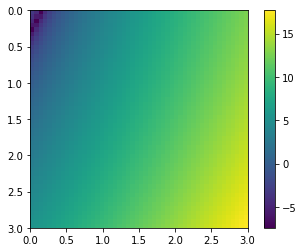

In [254]:
plt.imshow(np.log(integral_check),extent=[0,3,3,0])
#plt.axis('square')
plt.colorbar()

In [165]:
# class MeanGMM(GMM):

    
#     def __init__(self, *args, **kwds):
#         # set appropriate counts for moment conditions and parameters
#         # TODO: clean up signature
#         kwds.setdefault('k_moms', 2)
#         kwds.setdefault('k_params', 2)
#         super(MeanGMM, self).__init__(*args, **kwds)


#     def momcond(self, params):
                
#         y = self.endog[:, 0].reshape(-1, 1)
#         counts = self.endog[:, 1].reshape(-1, 1)
        
#         x_mat = self.exog

#         beta_hat = params.reshape(-1, 1)
        
#         a =  (x_mat*y)/self.q - (x_mat*np.exp(x_mat@beta_hat))
#         return a * counts
    
# class VarianceGMM(GMM):

    
#     def __init__(self, *args, **kwds):
#         # set appropriate counts for moment conditions and parameters
#         # TODO: clean up signature
#         kwds.setdefault('k_moms', 2)
#         kwds.setdefault('k_params', 2)
#         super(VarianceGMM, self).__init__(*args, **kwds)


#     def momcond(self, params):
                
#         y = self.endog[:, 0].reshape(-1, 1)
#         counts = self.endog[:, 1].reshape(-1, 1)
        
#         x_mat = self.exog
        
#         mean_beta = self.mean_beta.reshape(-1, 1)
#         var_beta = params.reshape(-1, 1)
        
#         a = (x_mat*y**2)/self.q_sq
#         b = -(x_mat*y)*(1-self.q_sq/self.q)/self.q_sq
#         c = -2*y*np.exp(x_mat@mean_beta)*x_mat/self.q
#         d = np.exp(2*x_mat@mean_beta)*x_mat
#         e = -x_mat*np.exp(x_mat@(self.gamma*mean_beta + var_beta))
#         return counts*(a + b + c + d + e)

In [177]:
(2*X*np.exp(X@beta_true.reshape(-1, 1))).mean(axis=0)

array([3.01462052, 4.11594544])

In [191]:
-(2*X*np.exp(X@beta_true.reshape(-1, 1))).T@X@W@X.T@(z-np.exp(X@beta_true.reshape(-1, 1)))/100000**2

array([[0.01481078],
       [0.01721467]])

In [41]:
objective(beta_true)

(2,)


0.00014312910540704592

### Poisson vs linear regression

In [207]:
X, z = sim.simulate_true_counts(
    N=10000,
    mean_coef = np.array([2, 3]),
    var_coef = np.array([1, 1]),
    num_levels=2,
    p=1)

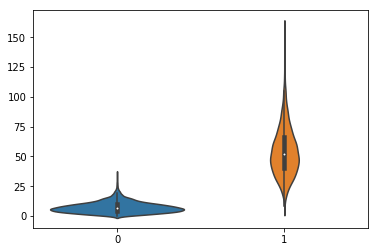

In [205]:
sns.violinplot(pd.Series(X[:, 0]), z.ravel())

In [209]:
log_z = np.log(z)

In [216]:
gaussian_model = sm.GLM(log_z, X).fit()
gaussian_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                         0.10292
Method:                          IRLS   Log-Likelihood:                -2819.4
Date:                Mon, 02 Mar 2020   Deviance:                       1029.0
Time:                        16:33:27   Pearson chi2:                 1.03e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.0336      0.006    316.944      0.000       2.021       2.046
const          2.9373      0.005    649.226      0.000       2.928       2.946
==============================================================================
"""

In [217]:
poisson_model = sm.GLM(z, X, family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -53826.
Date:                Mon, 02 Mar 2020   Deviance:                       49734.
Time:                        16:33:33   Pearson chi2:                 4.97e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.9891      0.003    594.636      0.000       1.983       1.996
const          3.0073      0.003    959.183      0.000       3.001       3.013
==============================================================================
"""